
# Basic quantification of trace element evolution in magmas using the ```magmatrace``` module
**Jordan Lubbers, Chuck Lewis** 

*Oregon State University <br>
College of Earth, Ocean, and Atmopheric Sciences*<br>

## Overview
This notebook will show you how to use the ```magmatrace``` module to quantify trace element evolution in magmas. Topics included:
- Partition coefficients
- Equilibrium melting and crystallization
- Fractional melting and crystallization
- Dynamic melting
- *in situ* crystallization


For more information on the derivations of the equations used, the reader is referred to either Rollinson (1993) *Using Geochemical Data* or White (2013) *Geochemistry*.

### Partition and Distribution coefficients
The distribution of a given trace element between two phases can be discribed as a ratio between their concentrations (McIntire, 1963). Commonly this is between glass, which represents a liquid composition of the magma and a mineral:
$$ \large{Kd = \frac{C_{element(i)}^{mineral}}{C_{element(i)}^{melt}}}$$


As volcanic and plutonic rocks are commonly not monomineralic, it is more accurate to describe the trace element evolution of a magma by the bulk partition coefficient (also known as a distribution coefficient). This can be thought of as the weighted sum of partition coefficients for all the minerals in a rock:
$$ \large{D_i = x_1Kd_1 + x_2Kd_2 + x_3Kd_3 ...}$$
where $x$ is the proportion of the mineral in the rock

The ```magmatrace``` module has the functions ```kd``` and ```bulk_kd``` to calculate these. Here we will use the following mineral assemblage 



In [1]:
import magmatrace_current as mt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# latex font style
## for Palatino and other serif fonts use:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    }
)

In [2]:
# create a dataframe for our mineral stuff
minerals = {
    "Mineral": ["A", "B", "C",],
    "Cs": np.array([5, 300, 100]),
    "Cl": np.array([1000, 1000, 1000]),
    "x": np.array([0.7, 0.2, 0.3]),
}

# creating a Dataframe object
df = pd.DataFrame(minerals)
df.set_index("Mineral", inplace=True)
df

,Cs,Cl,x
Mineral,,,
A,5,1000,0.7
B,300,1000,0.2
C,100,1000,0.3


The partition coefficient function takes two arguments:
1. Concentration in the solid phase
2. Concentration in the glass/liquid

In [3]:
# call the function and add the column to our dataframe
df["Kd"] = mt.kd(df["Cs"], df["Cl"])
df

,Cs,Cl,x,Kd
Mineral,,,,
A,5,1000,0.7,0.005
B,300,1000,0.2,0.300
C,100,1000,0.3,0.100


To calculate the distribution coefficient, we input the arguments
1. partition coefficient for a given mineral
2. fraction of mineral present

These can be arrays as well, so we apply this function to our dataframe columns 

In [4]:
Di = mt.bulk_kd(df["Kd"], df["x"])
print("The distribution coefficient is: ", Di)

The distribution coefficient is:  0.0935


## Melting Equations
While these are some of the more basic functions in ```magmatrace``` they set us up nicely to use some of the more complicated trace element evolution equations. We will now deal with the two endmember types of melting
1. equilibrium
2. fractional

both functions take the same inputs:
1. Concentration of the trace element in the original colid
2. Distribution coefficient in the unmelted solid (Di)
3. Fraction of melt generated
4. Distribution coefficient in the melting mineral assemblage (P)

The following are the equations used for the concentration of extracted melt via both non modal batch and fraction al melting

Non Modal Batch Melting:
$$ \large{C_L = \frac{C_0}{D_0 + F(1-P)}} $$

Non Modal Fractional Melting:
$$ \large{C_L = \frac{C_0}{L}\left[1-(1-F\frac{P}{D_0})^{\frac{1}{P}}\right]}$$

where $C_0$ is the concentration of the trace element in the unmelted solid, $F$ is the fraction of melt produced, $D_0$ is the distribution coefficient when $F = 0$, and $P$ is the distribution coefficient of the melting mineral assemblage


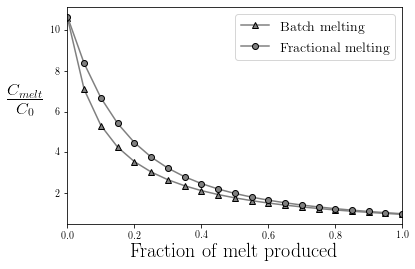

In [11]:
# Assume only A and B are melting
P = mt.bulk_kd(df["Kd"][:2], df["x"][:2])

# Assume the concentration of trace element in original solid is the total of the
# concentrations from the minerals
Cs_total = df["Cs"].sum()

# compute the concentration over a range of F values
F = np.arange(0.001, 1.05, 0.05)

# calculate the concentration of the liquid as per non modal batch
# and frac melting
Cl_batch = mt.non_modal_batch_melt(Cs_total, Di, F, P)
Cl_frac = mt.non_modal_frac_melt(Cs_total, Di, F, P)

# plot it up
fig, ax = plt.subplots()
ax.plot(F, Cl_batch / Cs_total, "^-", c="gray", mec="k", label="Batch melting")
ax.plot(F, Cl_frac / Cs_total, "o-", mec="k", c="gray", label="Fractional melting")

ax.legend(loc="upper right", fontsize=14)

ax.set_xlabel("Fraction of melt produced", fontsize=20)
ax.set_ylabel(r"$\frac{C_{melt}}{C_0}$", fontsize=24, rotation=0, labelpad=25)
ax.set_xlim(0, 1)
plt.show()

Because Equilibrium and Batch melting are endmember models to describe natural phenomenon, perhaps a more accurate representation of melting would be a situation where melt is in equilibrium with the surrounding residue up until a critical fraction, and then after that is reached, excess melt is extracted from the system. This is described in [Zhou, 1998](https://www.sciencedirect.com/science/article/pii/S001670379800115X?casa_token=uy4pB2Lm79oAAAAA:GO_ES59tVkfEeAGI3t0vA10FIG5_kwHRu3aM7CmgSRsAUZhK8OohQbVDeY0S5z5r1I6gpcb2Nw) and incorporated into the module with the ```non_modal_dynamic_melt``` function.

The equation for calculating the concentration of melt for a given melt fraction is as follows:
$$ \large{C_L = \frac{C_0}{X} \left[1 -\left[ \frac{X[P + \phi(1-P)]}{D_0+\phi(1-P)}\right]^{\frac{1}{\phi + (1-\phi)P}}\right]} $$

Here we add in the term $\phi$ which is the critical porosity at which melt begins to become extracted from the system. We also define $X$ as:
$$ X = \frac{F - \phi}{1-\phi}$$

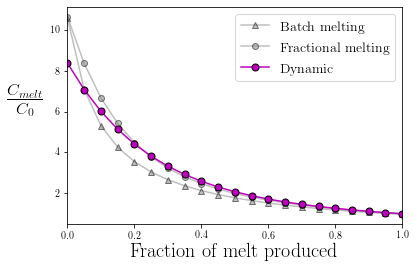

In [12]:
# the critical mass porosity for the residue
# this is the melt fraction when magma begins to be extracted
# when phi = 0 we have fractional melting
phi = 0.0511

# call the dynamic melting function
Cl_dynamic = mt.non_modal_dynamic_melt(Cs_total, Di, F, P, phi)

# plot it up
fig, ax = plt.subplots()
ax.plot(
    F, Cl_batch / Cs_total, "^-", mec="k", c="gray", label="Batch melting", alpha=0.5
)
ax.plot(
    F,
    Cl_frac / Cs_total,
    "o-",
    mec="k",
    c="gray",
    label="Fractional melting",
    alpha=0.5,
)
ax.plot(F, Cl_dynamic / Cs_total, "mo-", mec="k", ms=7, label="Dynamic")

ax.legend(loc="upper right", fontsize=14)
ax.set_xlabel("Fraction of melt produced", fontsize=20)
ax.set_ylabel(r"$\frac{C_{melt}}{C_0}$", fontsize=24, rotation=0, labelpad=25)
ax.set_xlim(0, 1)
plt.show()

## Crystallization Equations
As is often the case in magmatic systems, we transition from an environment that promotes melting to one that promotes crystallization. The two endmember types of crystallization are:
1. Equilibrium
2. Fractional

Similar to the melting equations in the module, we can quantify how melt evolves in a system where this is taking place by providing 3 arguments:
1. Concentration of the liquid
2. Bulk distribution coefficient of the crystallizing assemblage
3. Fraction of melt remaining

The following are the equations used for Equilibrium and Fractional crystallization:

Equilibrium Crystallization:
$$ \large{C_L = \frac{C_0}{F+D(1-F)}}$$

Fractional Crystallization:
$$ \large{C_L = C_0F^{D-1}} $$

Where $C_0$ is the concentration of the initial liquid, $F$ is the fraction of melt remaining, $D$ is the distribution coefficient of the crystallizing assemblage.

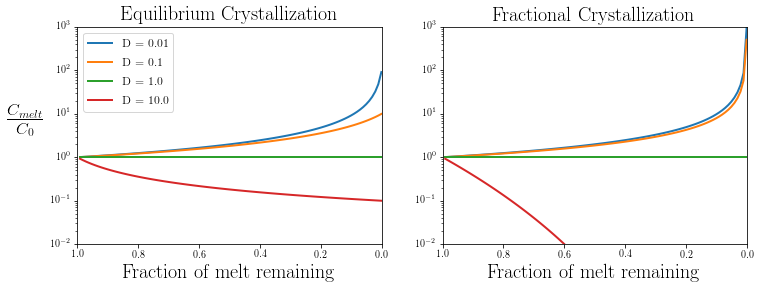

In [13]:
# concentration of the liquid prior to crystallization
Cl = 100
# F values
F = np.arange(0.001, 1, 0.01)

# range of distribution coefficients
Ds = np.array([0.01, 0.1, 1, 10])

# plot up curves for the range of D values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(len(Ds)):
    Cl_new_eq = mt.eq_xtl(Cl, Ds[i], F)
    Cl_new_frac, Cr_new_frac = mt.frac_xtl(Cl, Ds[i], F)

    ax[0].plot(F, Cl_new_eq / Cl, lw=2.0, label="D = {}".format(Ds[i]))
    ax[1].plot(F, Cl_new_frac / Cl, lw=2)
ax[0].set_yscale("log")
ax[0].set_ylim(1e-2, 1e3)
ax[0].set_xlim(1, 0)
ax[0].legend(loc="upper left", fontsize=12)
ax[0].set_title("Equilibrium Crystallization", fontsize=20)
ax[1].set_yscale("log")
ax[1].set_ylim(1e-2, 1e3)
ax[1].set_xlim(1, 0)

ax[1].set_title("Fractional Crystallization", fontsize=20)

ax[0].set_xlabel("Fraction of melt remaining", fontsize=20)
ax[1].set_xlabel("Fraction of melt remaining", fontsize=20)
ax[0].set_ylabel(r"$\frac{C_{melt}}{C_0}$", fontsize=24, rotation=0, labelpad=25)
plt.show()

Because these are also endmember situations, a more realistic example may be provided by a process called *in situ* crystallization. This was initially described by [Langmuir 1989](https://www.nature.com/articles/340199a0.pdf?origin=ppub) and can quantifies crystallization in a magma reservoir that dominantly takes place at the sidewalls and progressively works its way inwards. A key difference between this and fractional crystallization is that rather than crystals being removed from liquid via density driven separation, the liquid is extracted from the sidewall 'mush' via compaction. In magma trace we can call ```insitu_xtl``` to quantify this. It takes the sampe parameters as the above crystallization equations, however adds two parameters:
1. f = fraction of interstitial liquid remaining after crystallization within the solidification zone. It is assumed that some of this is trapped within the cumulate and the rest is returned to the magma
2. fa = fraction of f that is returned to the magma. When f = fa there is no interstitial liquid remaining in the crystallization front

In situ crystallization is defined as:
$$\large{C_L = C_0F^{\frac{f_A(E-1)}{f_A - 1}}} $$
where E:
$$ E = \frac{1}{D(1-f) + f)} $$

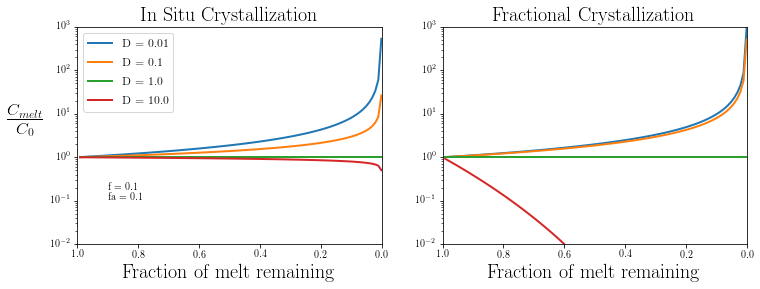

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
f = 0.1
fa = 1 * f
for i in range(len(Ds)):
    Cl_new_insitu = mt.insitu_xtl(Cl, Ds[i], F, f, fa)
    Cl_new_frac, Cr_new_frac = mt.frac_xtl(Cl, Ds[i], F)

    ax[0].plot(F, Cl_new_insitu / Cl, lw=2.0, label="D = {}".format(Ds[i]))
    ax[1].plot(F, Cl_new_frac / Cl, lw=2)
ax[0].set_yscale("log")
ax[0].set_ylim(1e-2, 1e3)
ax[0].set_xlim(1, 0)
ax[0].legend(loc="upper left", fontsize=12)
ax[0].set_title("In Situ Crystallization", fontsize=20)

ax[0].text(0.1, 0.2, "f = {} \n fa = {}".format(f, fa), transform=ax[0].transAxes)
ax[1].set_yscale("log")
ax[1].set_ylim(1e-2, 1e3)
ax[1].set_xlim(1, 0)

ax[1].set_title("Fractional Crystallization", fontsize=20)

ax[0].set_xlabel("Fraction of melt remaining", fontsize=20)
ax[1].set_xlabel("Fraction of melt remaining", fontsize=20)
ax[0].set_ylabel(r"$\frac{C_{melt}}{C_0}$", fontsize=24, rotation=0, labelpad=25)
plt.show()

Another common issue in igneous systems that the above equations do not address is the concept of changing distribution coefficients. To address this [Greenland 1970](https://pubs.geoscienceworld.org/msa/ammin/article-abstract/55/3-4_Part_1/455/540620) derived a solution to incorporate this. This is quantified in magmatrace using the ```fraclin_xtl``` function. The solution assumes a linear change in distribution coefficient with melt fraction and takes the parameters:
1. Concentration of the original liquid
2. slope of the linear relationship for distribution coefficient
3. intercept of the linear relationship for distribution coefficient
4. fraction of melt

This effectively mitigates the need to model phase proportions accurately, so long as the linear relationship for distribution coefficient evolves in a semi-accurate fashion. Below are two examples of trace element evolution in a magma. One where the environment evolves from being incompatible to compatible with increasing crystallization, and one that is the opposite.

The solution for quantifying the concentration via fractional crystallization where there is a linear change in D is:
$$ \large{C_L = C_0e^{\left[(a-1)lnF + b(F-1)\right] }} $$

where $a$ is the intercept of the linear relationship used to describe D and F, and $b$ is the slope of the same relationship.

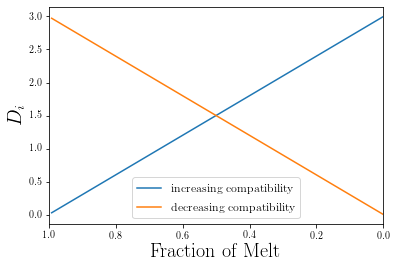

In [9]:
# create linear relationship between F and Di. This will effectively
# create a situation where the trace element goes from being incompatible
# to compatible as the system crystallizes
m = -3
b = 3

m2 = 3
b2 = 0

Di_lin = m * F + b
Di_lin2 = m2 * F + b2

fig, ax = plt.subplots()
ax.plot(F, Di_lin, label="increasing compatibility")
ax.plot(F, Di_lin2, label="decreasing compatibility")
ax.legend(loc="best", fontsize=12)
ax.set_xlabel("Fraction of Melt", fontsize=20)
ax.set_ylabel("$D_i$", fontsize=20)
ax.set_xlim(1, 0)

plt.show()

(0.0, 2.0)

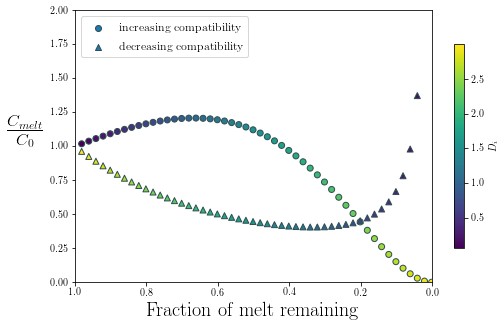

In [10]:
# call fraclin_xtl function
Cl_fraclin = mt.fraclin_xtl(Cl, b, m, F)
Cl_fraclin2 = mt.fraclin_xtl(Cl, b2, m2, F)

# plot
fig, ax = plt.subplots(figsize=(8, 5))
s = ax.scatter(
    F[::2],
    Cl_fraclin[::2] / Cl,
    c=Di_lin[::2],
    ec="darkslategray",
    label="increasing compatibility",
)
ax.scatter(
    F[::2],
    Cl_fraclin2[::2] / Cl,
    c=Di_lin2[::2],
    marker="^",
    ec="darkslategray",
    label="decreasing compatibility",
)

ax.set_xlabel("Fraction of melt remaining", fontsize=20)
ax.set_ylabel(r"$\frac{C_{melt}}{C_0}$", fontsize=24, rotation=0, labelpad=25)
ax.legend(loc="upper left", fontsize=12)
cbar = fig.colorbar(s, ax=ax, label="$D_i$", shrink=0.75)
ax.set_xlim(1, 0)
ax.set_ylim(0, 2)